# Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

# Descripción de los datos

El dataset proporcionado por la compañía es `telecom_dataset_us.csv` y contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

## Descomposición de tareas

### Descomposición de tareas

Es la fase actual del proyecto, en la cual __se desglosará el objetivo principal del informe en tareas individuales y organizadas__.

### Pre-procesamiento de datos

En esta etapa inicial se procurará realizar todos los preparativos necesarios para comenzar el análisis.
- __Importar librerías y datos__.
- __Trabajar los valores ausentes, duplicados y tipos de datos erróneos__.
- __Completar los datos: Crear una columnna con los tiempos de espera de las llamadas__.

### Análisis exploratorio de datos

En esta etapa se trabajará en la integridad de los datos y se observarán las distribuciones de los datos, rescatando conclusiones valiosas que se puedan apreciar a simple vista. Antes de comenzar con los cálculos sobre métricas clave, se dividirán los operadores en dos grupos:

- __Quienes hacen y reciben llamadas__.
- __Quienes solo reciben llamadas__.

Esto debido a que se usarán indices diferentes para cada uno de estos grupos. Una vez hecha la divsión, se comienza a el análisis exploratorio, comenzando por:

- __Analizar la integridad de los datos:__ esto requiere trabajar en.
    - __Determinar las fechas mínimas y máximas de recolección de datos__.
    - __Determinar si hay datos suficientes por día__.
    - __Llamadas de duración 0:__ Descubrir si hay registros de llamadas de duración 0 que no sean consideradas como perdidas, en caso de que así sea, serán debidamente omitidas de los análisis posteriores, mediante un drop si son una cantidad mínima, o una omisión puntual, en caso de que representen un porcentaje significativo de las llamadas.
    - __Outliers:__ Buscar y trabajar (en caso de ser necesario) outliers, mediante uso de percentiles extremos (entre el 95 y el 99), en los tiempos de espera de llamadas, cantidad de llamadas perdidas y en la cantidad de llamadas realizadas
- __Llamadas perdidas:__ Crear una métrica llamada "Tasa de contestación de llamadas" basada en promediar 0 y 1 según si la llamada fue perdida o contestada, para este campo no se considerarán las llamadas salientes ni las internas. El comportamiento de esta nueva métrica se visualizará con un histograma.
- __Tiempos de espera promedio:__ Construir un histograma con la distribución total de los tiempos de espera las llamadas, se dejarán fuera de este gráfico los tiempos de espera de llamadas salientes y, también, las llamadas internas.
- __Llamadas salientes semanales:__ Este campo se trabajará de manera semanal ya que es fácilmente actualizable y permite la incorporación de nuevos operadores al sistema sin desconfigurarlo, para este item no se contarán las llamadas internas y las llamadas salientes perdidas. Para visualizar este campo se usará un histograma.


### Identificar operadores ineficaces

Mediante un análisis de la cantidad de llamadas perdidas, tiempo de espera y cantidad de llamadas salientes, se categorizará a los operadores como; excelentes, buenos, regulares, malos y muy malos. El sistema estará basado en percentiles, para lo cual se calcularán los percentiles 10, 20, 30, 40, 50, 60, 70, 80, 90 y 100 de los campos a evaluar. Lo anterior será traducido en notas que al promediarse/ponderarse nos entregarán una calificación final sobre los operadores.

La identificación será realizada para cada uno de los grupos determinados anteriormente (operadores que llaman y reciben llamadas, y operadores que solo recibe llamadas). Los pasos para llevarla a cabo son los siguientes.

- __Tasa de contestación de llamadas:__ Aplicar los filtros de outliers y de tipo de llamadas, agrupar por operador y sacar los 10 percentiles requeridos para el índice.
- __Tiempo medio de espera:__ Aplicar los filtros de outliers y de tipo de llamadas, agrupar por operador y sacar los 10 percentiles requeridos para el índice. Este valor deberá ser invertido, ya que a diferencia de los otros, mientras más grande es el valor, es menor la calificación que debe entregar.
- __Llamadas salientes semanales__: Aplicar los filtros de outliers y de tipo de llamadas, agrupar por operador y por semana, y sacar los 10 percentiles requeridos para el índice.
- __Desarrollar funciones de clasificación:__ Usando los percentiles obtenidos en conjunto con funciones se ingresarán las calificaciones de 1 a 10 al dataset agrupado por operador.
- __Ponderación:__ Para el grupo de operadores que solo reciben llamadas, se calculará la media entre las dos medidas usadas: Tiempo medio de espera y Tasa de contestación de llamadas, en cambio, para el grupo que hace y recibe llamadas, se construirá un índice ponderado de la siguiente manera:
    - __Tasa de contestación de llamadas__: 40% de la calificación final.
    - __Tiempo medio de espera__: 40% de la calificación final.
    - __Llamadas salientes semanales__: 20% de la calificación final.
- __Categorización:__ Finalmente, se categorizarán las calificaciones finales de la siguiente manera:
    - __Excelente__: Más de 8.
    - __Bueno__: Entre 6 y 8.
    - __Regular__: Entre 4 y 6.
    - __Malo__: Entre 2 y 4.
    - __Muy Malo__: Menos de 2.

### Pruebas de hipótesis

En esta etapa se comprueba estadísticamente la diferencia entre el rendimiento de operadores del grupo "Regular" y del grupo "Malo" del grupo de operadores que hace y recibe llamadas. Las hipótesis a probar son las siguientes:

- __La tasa de contestación de llamadas de operadores "regulares" es más alta que la de operadores "malos"__.
- __La media de los tiempos de espera de operadores "malos" es mayor que que la de operadores "regulares"__.
- __La media de llamadas salientes semanales de operadores "regulares" es mayor que la de operadores "malos"__.

### Clustering

En esta fase, usará el modelo de aprendizaje no supervisado `KMeans` para establecer grupos clave entre los operadores que hacen y reciben llamadas, para lo cual se deberán seguir los siguientes pasos.
- __Preparativos__: Realizar las divisiones correspondientes, escalar y trazar un dendrograma en los datos para saber la cantidad de clústers con las que se trabajará.
- __Ejecutar el modelo__: Se llamará a `KMeans` para que genere la cantidad de clústers correspondiente.
- __Análisis__: Con los clústers creados se analizarán las características de los con mayor y menor rendimiento, también, se trazarán gráficos de correlación para explorar las relaciones entre las variables.

### Conclusiones

En esta etapa se rescatan las conclusiones más importantes de todo el proyecto.

- __Resumen de los hallazgos clave:__ Se incluyen los descubrimientos más importantes.
- __Impacto de las elecciones de procesamiento de datos:__ Reflexión sobre cómo las decisiones decisiones tomadas influyeron en los resultados.
- __Relevancia de los hallazgos y sugerencias:__ La importancia de los resultados para la empresa.
- __Reflexiones finales:__ Pensamientos finales sobre el proyecto.

## Preprocesamiento de datos

Una vez repasadas la descripción de datos y la descomposición de tareas, se da inicio al proyecto.

### Importación de librerías y datos

Se comienza importando las librerías necesarias para analizar, visualizar y realizar pruebas estadísticas en los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
import statsmodels.stats.multitest as smm
import math as mt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Una vez importadas las librerías, se cargan los datos que serán utilizados para el desarrollo del proyecto.

In [2]:
telecom = pd.read_csv('/datasets/telecom_dataset_us.csv', parse_dates=['date'])
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Se importa correctamente el dataset y se muestran las primeras cinco filas para asegurar que todo esté en orden. Una vez cargadas las librerías, procedemos a limpiar los datos, es decir, trabajar valores duplicados, ausentes y tipos de datos erróneos.

### Pre-visualización de datos

Comenzamos visualizando información general del dataset con el método `.info()`.

In [3]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

Tenemos valores ausentes en la columna `operator_id` que serán eliminados, esto debido a que nuestro foco está en la __individualidad__ de los operadores, por lo que cualquier fila que no contenga el id de operador no sirve para este propósito (si fuera un análisis sobre el rendimiento general de los operadores, se tomarían medidas diferentes).

También hay valores ausentes en `internal` que serán eliminados, debido a que son un porcentaje ínfimo del total.

El tipo de datos de `operator_id` es `float64`, lo que puede traer problemas más adelante, por lo que, considerando que será una columna clave en el informe, se convertirá a `int`.

### Valores ausentes y tipos de datos

Ahora nos hacemos cargo de los errores encontrados en el apartado anterior.

In [4]:
telecom = telecom.dropna()
telecom['operator_id'] = telecom['operator_id'].astype('int')

El dataset está libre de valores ausentes y con sus tipos de datos aduecuados para poder trabajarlo.

### Valores duplicados

Ahora se buscarán filas y valores duplicados en el dataset, y serán trabajados de acuerdo a las necesidades del proyecto.

In [5]:
print('duplicados encontrados:' ,telecom.duplicated().sum())
duplicated = telecom[telecom.duplicated()]
print('El porcentaje de duplicados respecto del total es de:', format((len(duplicated) / len(telecom)), '.1%'))
duplicated.head()

duplicados encontrados: 4179
El porcentaje de duplicados respecto del total es de: 9.2%


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
44,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654
51,166377,2019-08-15 00:00:00+03:00,out,False,880026,False,11,1413,1473
62,166377,2019-08-19 00:00:00+03:00,out,False,880026,False,14,1519,1598
78,166377,2019-08-22 00:00:00+03:00,out,False,880026,True,6,0,55


Se encuentran 4184 filas completamente duplicadas, al ser una cantidad tan grande, visualizamos las primeras 5 líneas para detectar algun valor en común. Se revisará columna por columna para determinar si es seguro eliminar los duplicados y si podemos detectar la causa de estos mismos, se considerará riesgoso si los duplicados llegasen a cambiar las proporciones generales de valores en alguna columna.

Comenzamos definiendo una función para automatizar el proceso de revisión de las columnas booleanas.

In [6]:
def printer(column):
    
    print(column)
    print()
    print(telecom[column].value_counts())
    print()
    print(duplicated[column].value_counts())
    print()

Una vez la función está construída, la aplicamos en las columnas correspondientes.

In [7]:
printer('is_missed_call')
printer('internal')
printer('direction')

is_missed_call

False    30153
True     15517
Name: is_missed_call, dtype: int64

False    2771
True     1408
Name: is_missed_call, dtype: int64

internal

False    39861
True      5809
Name: internal, dtype: int64

False    3700
True      479
Name: internal, dtype: int64

direction

out    31717
in     13953
Name: direction, dtype: int64

out    2904
in     1275
Name: direction, dtype: int64



Sin necesidad de cálculos podemos darnos cuenta de que los duplicados no generan un impacto significativo en el dataset y mantienen las proporciones generales.

Ahora definimos una función para las columnas numéricas.

In [8]:
def describer(column):
    
    print(column)
    print()
    print(telecom[column].describe())
    print()
    print(duplicated[column].describe())
    print()

Y la aplicamos en las columnas correspondientes.

In [9]:
describer('calls_count')
describer('call_duration')
describer('total_call_duration')

calls_count

count    45670.000000
mean        16.925203
std         59.081220
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       4817.000000
Name: calls_count, dtype: float64

count    4179.000000
mean       16.963149
std        51.568065
min         1.000000
25%         2.000000
50%         4.000000
75%        14.000000
max      1241.000000
Name: calls_count, dtype: float64

call_duration

count     45670.000000
mean       1010.934399
std        4017.101865
min           0.000000
25%           0.000000
50%         107.000000
75%         774.000000
max      144395.000000
Name: call_duration, dtype: float64

count     4179.000000
mean      1010.878679
std       3487.419059
min          0.000000
25%          0.000000
50%        115.000000
75%        793.500000
max      80782.000000
Name: call_duration, dtype: float64

total_call_duration

count     45670.000000
mean       1323.697000
std        4735.336635
min           0.000000
25%        

Podemos observar que la información estadística descriptiva de los duplicados y la del dataset completo son prácticamente iguales, por lo que (hasta este momento) es seguro remover los duplicados.

A continuación, se revisará si la fecha de recolección tiene incidencia en la aparición de duplicados.

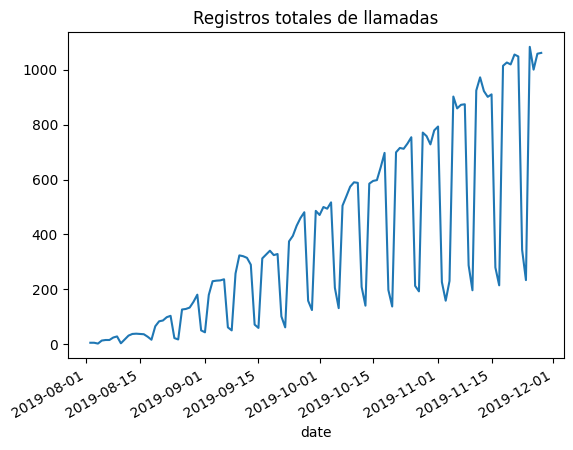

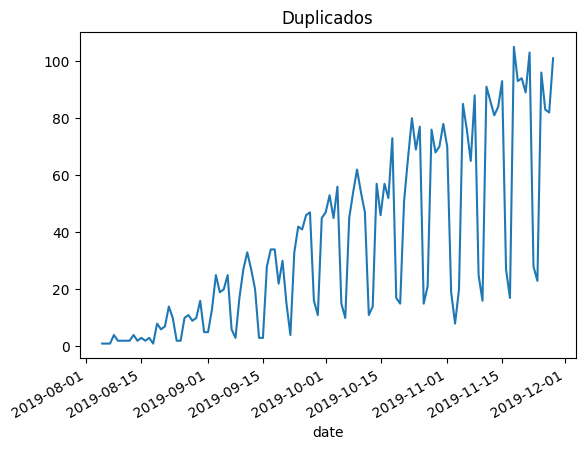

In [10]:
telecom.groupby('date')['user_id'].count().plot(title='Registros totales de llamadas')
plt.show()
duplicated.groupby('date')['user_id'].count().plot(title='Duplicados')
plt.show()

Se observa que la aparición de duplicados aumenta a la par con la cantidad de llamadas recolectadas, lo que quiere decir que de todas las llamadas recopiladas diariamente, se duplica por error un pequeño porcentaje en la base de datos.

Se determina que __es seguro eliminar los duplicados__.

In [11]:
telecom = telecom.drop_duplicates()

Los duplicados son eliminados exitosamente.

### Completar datos

No existe una columna que especifique el tiempo de espera, por lo cual vamos a crearla SEGUIR

In [12]:
telecom['wait_time'] = telecom['total_call_duration'] - telecom['call_duration']
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26


## Análisis exploratorio de datos

En esta fase, se trabajará la integridad de los datos, rescatando conclusiones importantes y preparando los datos para el sistema de clasificación de los operadores.

### Llamadas de duración 0

Cuando se trabaja con datasets de llamadas es común encontrar llamadas no perdidas con duración 0, estos valores podrían afectar al sistema de clasificación por lo que es necesario trabajarlos.

In [13]:
len(telecom[(telecom['call_duration'] == 0) & (telecom['is_missed_call'] == 'True')])

0

No se encuentran llamadas no perdidas con duración 0.

### Fecha mínima y máxima de recolección

Se extraerán las fechas mínimas y máximas de los datos para saber cuánto duró la recolección.

In [14]:
print(telecom['date'].min())
print(telecom['date'].max())

2019-08-02 00:00:00+03:00
2019-11-28 00:00:00+03:00


Tenemos registro desde inicios de agosto hasta fines de noviembre, casi tres meses.

### Tasa de contestación

Para analizar la distribución de llamadas perdidas se deben filtrar sólo las que tienen dirección `in` ya que son las que afectarán a nuestro sistema de calificación, se realizará una agrupación semanal, debido a que nuestro indice funcionará con valores semanales.

Para analizar las llamadas perdidas __se creará una métrica llamada "tasa de contestación de llamadas"__ en donde se creará una columna con valor `0` si la llamada es perdida y un `1` si la llamada fue contestada, para posteriormente generar un promedio semanal de esta métrica por cada uno de los operadores correspondientes.

In [15]:
def answering_rate(row):
    
    missed = row['is_missed_call']
    
    if missed == True:
        return 0
    else:
        return 1
    
telecom = telecom.copy()
telecom['answering_rate'] = telecom.apply(answering_rate, axis=1)
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,answering_rate
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8,1
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25,0
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26,1


Una vez aplicada la columna, procedemos a dividir a los operadores en dos grupos: quienes hacen y reciben llamadas, y quienes solo reciben llamadas.

#### Operadores que hacen y reciben llamadas

Para comenzar con la divisón, crearemos una variable `operators` donde estarán todos los id de los operadores que han realizado al menos una llamada saliente no interna.

In [16]:
operators = telecom[(telecom['direction'] == 'out') & (telecom['internal'] == False)]['operator_id'].unique() # Filtro de operadores

Una vez lista la variable, creamos `ar1` que es un dataset con información de llamadas entrantes externas de los operadores que filtramos en el bloque anterior. Con la variable creada visualizamos información sobre la tasa de contestación para este grupo.

count    516.000000
mean       0.956769
std        0.090134
min        0.000000
25%        0.949342
50%        1.000000
75%        1.000000
max        1.000000
Name: answering_rate, dtype: float64


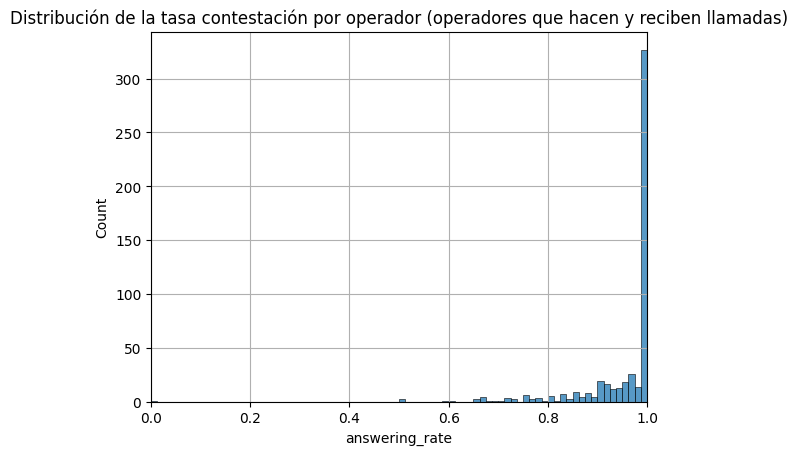

El porcentaje de operadores con una tasa de contestación perfecta es de: 63.2%


In [17]:
ar1 = telecom[(telecom['operator_id'].isin(operators)) & (telecom['direction'] == 'in') & (telecom['internal'] == False)] #Filtro de operadpres y llamadas
ar1 = ar1.groupby('operator_id')['answering_rate'].mean()

print(ar1.describe()) #Mostrar info descriptiva

sns.histplot(ar1) #Visualizar histograma
plt.title('Distribución de la tasa contestación por operador (operadores que hacen y reciben llamadas)')
plt.xlim(0, 1)
plt.grid(True)
plt.show()

percent = ar1.reset_index() #Calcular porcentaje de perfección
percent = percent[percent['answering_rate'] == 1]
print('El porcentaje de operadores con una tasa de contestación perfecta es de:', format((len(percent) / len(ar1)), '.1%'))

Se observa que __un porcentaje de 63.2% tiene una tasa de contestación perfecta__, lo cual, son buenas noticias.

#### Operadores que sólo reciben llamadas

Ahora, usando la lógica negativa, excluimos a los operadores del grupo anterior para quedarnos con los que solo reciben llamadas, y de estos operadores rescatamos las llamadas entrantes externas en la variable `ar2`.

count    222.000000
mean       0.976992
std        0.069767
min        0.500000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: answering_rate, dtype: float64


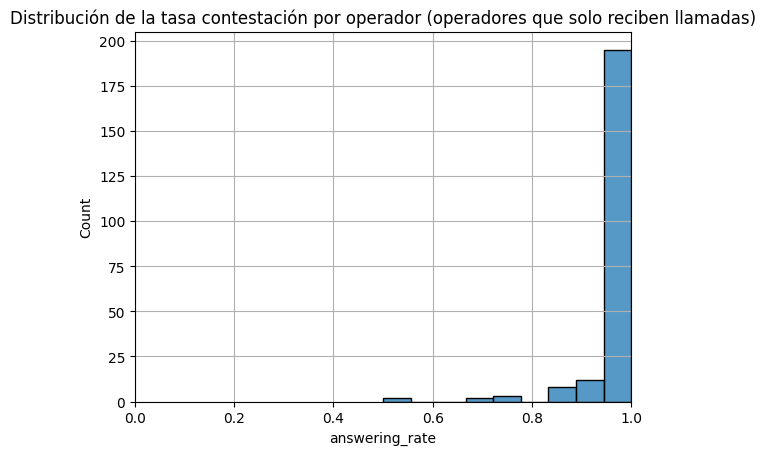

El porcentaje de operadores con una tasa de contestación perfecta es de: 81.5%


In [18]:
ar2 = telecom[(telecom['direction'] == 'in') & (telecom['internal'] == False) & (~telecom['operator_id'].isin(operators))] #Filtrar operadores y llamadas
ar2 = ar2.groupby('operator_id')['answering_rate'].mean()

print(ar2.describe()) #Visualizar información descriptiva

sns.histplot(ar2) #Construir histograma
plt.title('Distribución de la tasa contestación por operador (operadores que solo reciben llamadas)')
plt.xlim(0, 1)
plt.grid(True)
plt.show()

percent = ar2.reset_index() #Calcular porcentaje de perfección
percent = percent[percent['answering_rate'] == 1]
print('El porcentaje de operadores con una tasa de contestación perfecta es de:', format((len(percent) / len(ar2)), '.1%'))

Podemos darnos cuenta que __la media de este grupo es superior a la del grupo anterior, también, lo es el porcentaje de operadores con tasa de contestación perfecta__, en un 18.3%.

### Tiempos de espera

Mediante agrupaciones, se calculará, para cada grupo, el tiempo medio de espera de llamada para cada operador con su respectiva información descriptiva, además, se calculará para cada grupo, el porcentaje de operadores que tengan menos de un minuto en sus tiempos de espera promedio.

#### Operadores que hacen y reciben llamadas

Comenzamos visualizando la información necesaria de forma casi idéntica a como lo hicimos con los tiempos de espera.

count    9318.000000
mean      118.265830
std       210.870411
min         0.000000
25%        19.000000
50%        47.000000
75%       123.750000
max      3998.000000
Name: wait_time, dtype: float64


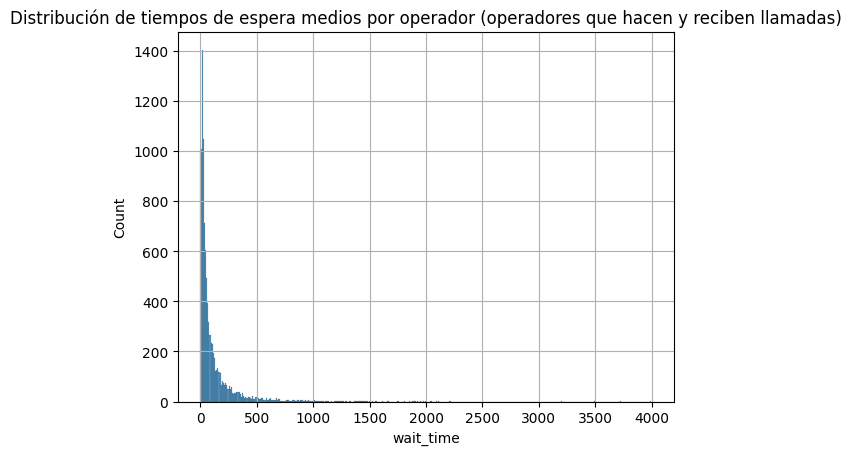

El porcentaje de llamadas con un tiempo de espera menor a un minuto es de: 56.6%


In [19]:
wt1 = telecom[(telecom['is_missed_call'] == False) & (telecom['internal'] == False) & (telecom['direction'] == 'in') & (telecom['operator_id'].isin(operators))] #Agrupar
print(wt1['wait_time'].describe()) # Visualizar info descriptiva

sns.histplot(wt1['wait_time']) #Construir histograma
plt.title('Distribución de tiempos de espera medios por operador (operadores que hacen y reciben llamadas)')
plt.grid(True)
plt.show()

percent = wt1['wait_time'].reset_index() # Calculo para porcentaje de llamadas con menos de 1m de tiempo de espera
percent = percent[percent['wait_time'] < 60]
print('El porcentaje de llamadas con un tiempo de espera menor a un minuto es de:', format((len(percent) / len(wt1)), '.1%'))

En esta métrica __se observan muy buenos resultados__ también, sin embargo, __se detectan valores anormalmente altos que podrían afectar el funcionamiento de nuestro sistema de clasificación__, estos valores serán debidamente tratados más adelante.

#### Operadores que solo reciben llamadas

Procedemos a visualizar ahora la información del segundo grupo.

count    2311.000000
mean       45.222415
std        47.713501
min         0.000000
25%        17.000000
50%        30.000000
75%        56.000000
max       585.000000
Name: wait_time, dtype: float64


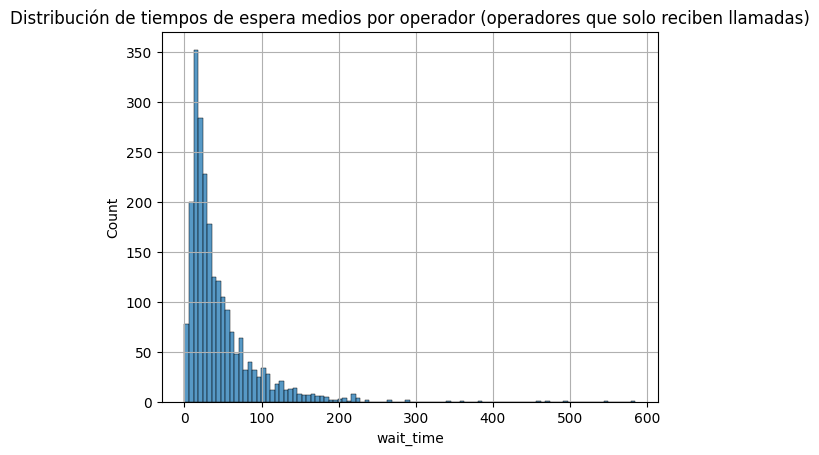

El porcentaje de llamadas con un tiempo de espera menor a un minuto es de: 77.1%


In [20]:
wt2 = telecom[(telecom['is_missed_call'] == False) & (telecom['internal'] == False) & (telecom['direction'] == 'in') & (~telecom['operator_id'].isin(operators))] #Agrupar y filtrar

print(wt2['wait_time'].describe()) # Visualizar info descriptiva

sns.histplot(wt2['wait_time']) #Construir histograma
plt.title('Distribución de tiempos de espera medios por operador (operadores que solo reciben llamadas)')
plt.grid(True)
plt.show()

percent = wt2['wait_time'].reset_index() # Calculo para porcentaje de llamadas con menos de 1m de tiempo de espera
percent = percent[percent['wait_time'] < 60]
print('El porcentaje de llamadas con un tiempo de espera menor a un minuto es de:', format((len(percent) / len(wt2)), '.1%'))

Aquí la diferencia entre grupos (media y mediana) es más grande que en la comparación de tasas de contestación, sin embargo, __este conjunto de datos posee valores atípicos mucho más pequeños__ que el conjunto de los operadores que hacen y reciben llamadas. En cuanto al porcentaje de llamadas con tiempo de espera menor a un minuto, en este grupo es un __20.5% mayor__ que en el grupo que operadores que realizan llamadas.

### Llamadas salientes

Para nuestro indice de clasificación, se trabajará con la media de llamadas salientes semanales por operador. Antes de agrupar, debemos dejar fuera las llamadas internas y las llamadas perdidas.

count    3765.000000
mean        3.409031
std         1.764427
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: user_id, dtype: float64


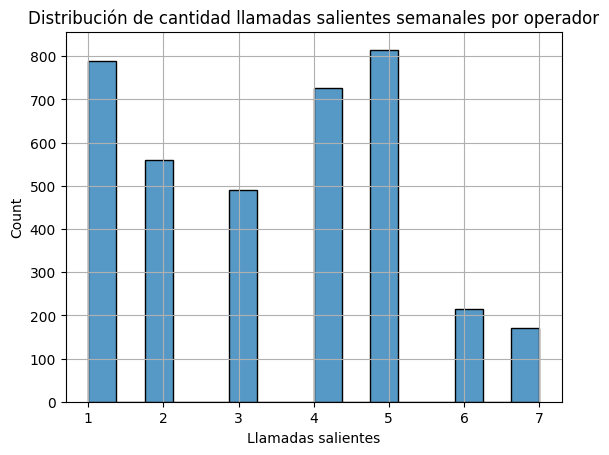

El porcentaje de operadores que hacen en promedio más de 3.5 llamadas semanales es de: 51.1%


In [21]:
out_calls = telecom[(telecom['direction'] == 'out') & (telecom['internal'] == False) & (telecom['is_missed_call'] == False)] # Agrupar y filtrar
out_calls = out_calls.copy()
out_calls['week'] = out_calls['date'].dt.week
out_calls = out_calls.groupby(['operator_id', 'week'])['user_id'].count().reset_index()

print(out_calls['user_id'].describe()) #Visualizar
sns.histplot(out_calls['user_id'])
plt.grid(True)
plt.xlabel('Llamadas salientes')
plt.title('Distribución de cantidad llamadas salientes semanales por operador');
plt.show()

percent = out_calls['user_id'].reset_index() #Calculo de porcentaje registros semanales de operadores que hicieron más de 3.5 llamadas semanales
percent = percent[percent['user_id'] > 3.5]
print('El porcentaje de operadores que hacen en promedio más de 3.5 llamadas semanales es de:', format((len(percent) / len(out_calls)), '.1%'))

En esta campo, el rendimiento de los operadores se observa parejo, __hay un gran grupo de operadores que sólo hacen una llamada en promedio a la semana__, lo cual es un área de mejora. Los porcentajes indican que prácticamente __la mitad de los registros semanales de operadores indican una cantidad media semanal de llamadas salientes aceptable__.

### Trabajar outliers

Los valores anormalmente grandes pueden afectar enormemente los resultados de nuestro informe, por lo que visualizaremos las dispersiones de los campos de estudio y estableceremos filtros en caso de ser necesario. En el caso de la tasa de contestación, al tratarse de una métrica que va desde 0 a 1, no contará con valores atípicos influyentes, por lo cual, no figurará en este apartado.

#### Tiempos de espera

Anteriormente, se detectaron valores anormalmente grandes en los tiempos de espera por operador (`wait_time`), esto puede causar problemas en nuestro indice de clasificación basado en percentiles, por lo cual estos serán filtrados a la hora de construir dicho índice. Para saber donde debemos poner el filtro, visualizaremos la distribución de los datos y calcularemos percentiles extremos.

##### Operadores que llaman y reciben llamados

En el siguiente bloque de código realizaremos todos los cálculos para poder determinar el umbral de filtrado de outliers.

[ 286.3   470.3  1014.83]

count    9318.000000
mean      118.265830
std       210.870411
min         0.000000
25%        19.000000
50%        47.000000
75%       123.750000
max      3998.000000
Name: wait_time, dtype: float64


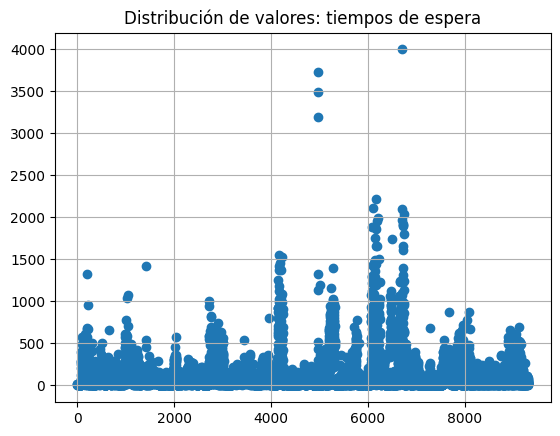

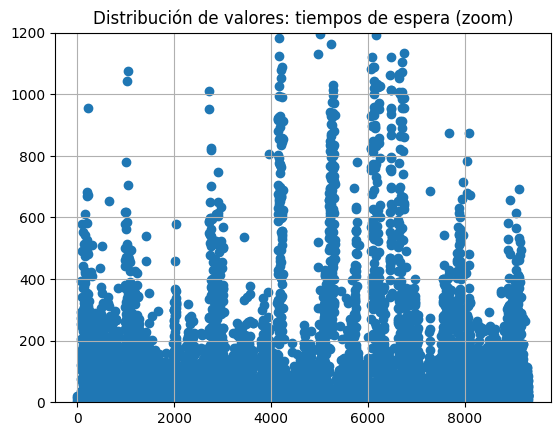

In [22]:
print(np.percentile(wt1['wait_time'], [90, 95, 99])) #Percentiles
print()
print(wt1['wait_time'].describe()) # Información descriptiva

x_values = pd.Series(range(0, len(wt1))) #Visualización
plt.scatter(x_values, wt1['wait_time'])
plt.title('Distribución de valores: tiempos de espera')
plt.grid(True)
plt.show()

x_values = pd.Series(range(0, len(wt1)))
plt.scatter(x_values, wt1['wait_time'])
plt.title('Distribución de valores: tiempos de espera (zoom)')
plt.ylim(0, 1200)
plt.grid(True)
plt.show()

Se observan en este conjunto de datos valores atípicos muy grandes, tanto, que se hace necesario construir un nuevo gráfico con "zoom". En base a la información de los percentiles y del gráfico, __situaremos el umbral en 600 segundos (10 minutos) todo tiempo de espera superior a este umbral, será filtrado para efectos del sistema de clasificación__, la pérdida de datos será entre el 5% y el 1%.

##### Operadores que solo reciben llamadas

De forma idéntica al grupo anterior, identificaremos los outliers para el grupo de operadores que solo recibe llamadas.

[100. 132. 218.]

count    2311.000000
mean       45.222415
std        47.713501
min         0.000000
25%        17.000000
50%        30.000000
75%        56.000000
max       585.000000
Name: wait_time, dtype: float64


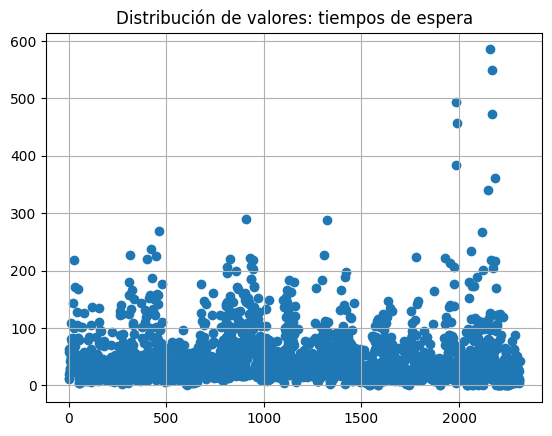

In [23]:
print(np.percentile(wt2['wait_time'], [90, 95, 99]))
print()
print(wt2['wait_time'].describe())

x_values = pd.Series(range(0, len(wt2)))
plt.scatter(x_values, wt2['wait_time'])
plt.title('Distribución de valores: tiempos de espera')
plt.grid(True)

En este caso, __el filtro será configurado en los 180 segundos__ (3 minutos), usando nuevamente un umbral entre el percentil 95 y 99.

#### Llamadas salientes

Calculamos percentiles y creamos el gráfico de dispersión.

[6. 6. 7.]

count    3765.000000
mean        3.409031
std         1.764427
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: user_id, dtype: float64


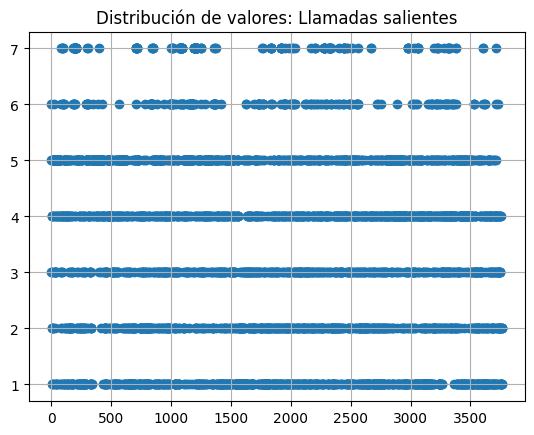

In [24]:
print(np.percentile(out_calls['user_id'], [90, 95, 99]))
print()
print(out_calls['user_id'].describe())

x_values = pd.Series(range(0, len(out_calls)))
plt.scatter(x_values, out_calls['user_id'])
plt.title('Distribución de valores: Llamadas salientes')
plt.grid(True)

Considerando la información obtenida por el gráfico y el cálculo de percentiles, pondremos el filtro 6 llamadas semanales (entre el percentil 95 y el 99), lo que significa que __todo registro superior a 6 llamadas salientes semanales, será filtrado a la hora de construir el índice__.

## Identificar operadores ineficaces

Para identificar a los operadores ineficaces hara una división entre operadores que hacen y reciben llamadas y operadores que solo reciben llamadas, construyendo una escala diferente para cada uno de ellos.

### Operadores que hacen y reciben llamadas

Se comenzará calculando los percentiles clave (10, 20, 30, 40, 50, 60, 70, 80 y 90) y posteriormente se asignarán calificaciones de 1 a 10 basadas en los percentiles.

#### Cálculo de percentiles para los campos a evaluar

Comenzamos calulando los percentiles para las medias de llamadas salientes semanales usando la variable declarada anteriormente `out_calls`, antes de calcular los percentiles debemos aplicar el filtro de outliers "menor o igual a 7".

In [25]:
out_calls = out_calls[out_calls['user_id'] <= 6] #Aplicar filtro outliers
out_calls = out_calls.groupby('operator_id')['user_id'].mean() #Promediar registros semanales
print(np.percentile(out_calls, [10, 20, 30, 40, 50, 60, 70, 80, 90])) #Cálculo de percentiles clave

[1.         1.33333333 1.75       2.         2.71428571 3.14285714
 3.5        4.         4.5       ]


Continuamos con la tasa de contestación semanal.

In [26]:
print(np.percentile(ar1, [10, 20, 30, 40, 50, 60, 70, 80, 90]))

[0.85714286 0.92307692 0.96609195 1.         1.         1.
 1.         1.         1.        ]


Y terminamos con los tiempos de espera promedio, aplicando antes, el filtro de outlier "menor o igual que 600 segundos".

In [27]:
wt1 = wt1[wt1['wait_time'] <= 600]
wt1 = wt1.groupby('operator_id')['wait_time'].mean()
print(np.percentile(wt1, [10, 20, 30, 40, 50, 60, 70, 80, 90]))

[ 11.61185185  16.58        22.45194805  29.3         36.
  46.49166667  60.87672634  88.55907928 165.37241379]


Una vez listos los percentiles, estamos preparados para comenzar a asignar calificaciones.

#### Calificación

Para comenzar la calificación, necesitamos tener un dataset con la información clave de cada operador, que es:

- __Tasa de contestación de llamadas__.
- __Tiempo de espera promedio__.
- __Media de llamadas salientes semanales__.

Para ello, combinamos los datos trabajados anteriormente trabajados para crear `standard1`.

In [28]:
standard1 = ar1.reset_index().merge(wt1.reset_index(), on='operator_id')
standard1 = standard1.merge(out_calls.reset_index(), on='operator_id')
standard1 = standard1.rename(columns={'user_id':'calls_made'})
standard1.head()

,operator_id,answering_rate,wait_time,calls_made
0,879896,1.0,27.333333,3.142857
1,879898,1.0,29.875000,4.388889
2,880020,1.0,7.714286,3.000000
3,880022,1.0,14.000000,2.750000
4,880026,1.0,7.944444,4.529412


Una vez creado el dataset, creamos funciones para clasificar los valores clave mediante los percentiles extraídos en el apartado anterior, los valores de los percentiles serán redondeados a la centésima. Comenzamos con la función de llamadas salientes semanales.

In [29]:
def out_classifier(row):
    
    calls_made = row['calls_made']
    
    if calls_made >= 4.5:
        return 10
    elif calls_made >= 4:
        return 9
    elif calls_made >= 3.5:
        return 8
    elif calls_made >= 3.14:
        return 7
    elif calls_made >= 2.71:
        return 6
    elif calls_made >= 2:
        return 5
    elif calls_made >= 1.75:
        return 4
    elif calls_made >= 1.33:
        return 3
    elif calls_made >= 1:
        return 2
    else:
        return 1
    
standard1['out_p'] = standard1.apply(out_classifier, axis=1)
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p
0,879896,1.0,27.333333,3.142857,7
1,879898,1.0,29.875000,4.388889,9
2,880020,1.0,7.714286,3.000000,6
3,880022,1.0,14.000000,2.750000,6
4,880026,1.0,7.944444,4.529412,10


Una vez creada la función, se aplica al dataset creando la columna `out_p` que es una calificación de 1 a 10 basada en los percentilos extraídos anteriormente.

Repetimos el proceso para los otros dos valores clave, tasa de constestación de llamadas (percentiles redondeados a la milésima) y tiempo de espera promedio (percentiles redondeados a la centésima).

In [30]:
def answering_classifier1(row):
    
    answering_rate = row['answering_rate']
    
    if answering_rate >= 1:
        return 10
    elif answering_rate >= 0.966:
        return 4
    elif answering_rate >= 0.923:
        return 3
    elif answering_rate >= 0.857:
        return 2
    else:
        return 1
    
standard1['answering_p'] = standard1.apply(answering_classifier1, axis=1)
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p,answering_p
0,879896,1.0,27.333333,3.142857,7,10
1,879898,1.0,29.875000,4.388889,9,10
2,880020,1.0,7.714286,3.000000,6,10
3,880022,1.0,14.000000,2.750000,6,10
4,880026,1.0,7.944444,4.529412,10,10


In [31]:
def wait_classifier1(row):
    
    wait_time = row['wait_time']
    
    if wait_time >= 165.37:
        return 10
    elif wait_time >= 88.56:
        return 9
    elif wait_time >= 60.87:
        return 8
    elif wait_time >= 46.49:
        return 7
    elif wait_time >= 36:
        return 6
    elif wait_time >= 29.3:
        return 5
    elif wait_time >= 22.45:
        return 4
    elif wait_time >= 16.58:
        return 3
    elif wait_time >= 11.61:
        return 2
    else:
        return 1
    
standard1['wait_p'] = standard1.apply(wait_classifier1, axis=1)
standard1['wait_p'] = 10 - standard1['wait_p']
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p,answering_p,wait_p
0,879896,1.0,27.333333,3.142857,7,10,6
1,879898,1.0,29.875000,4.388889,9,10,5
2,880020,1.0,7.714286,3.000000,6,10,9
3,880022,1.0,14.000000,2.750000,6,10,8
4,880026,1.0,7.944444,4.529412,10,10,9


Ya tenemos todas las calificaciones que necesitamos, ahora debemos ponderarlas mediante multiplicaciones para obtener la calificación final. Los porcentajes de incidencia son:

- __Media de llamadas salientes semanales:__ 20%.
- __Tasa de contestación de llamadas:__ 40%.
- __Tiempo de espera medio:__ 40%.

In [32]:
standard1['score'] = (standard1['out_p'] * 0.2) + (standard1['answering_p'] * 0.4) + (standard1['wait_p'] * 0.4)
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p,answering_p,wait_p,score
0,879896,1.0,27.333333,3.142857,7,10,6,7.8
1,879898,1.0,29.875000,4.388889,9,10,5,7.8
2,880020,1.0,7.714286,3.000000,6,10,9,8.8
3,880022,1.0,14.000000,2.750000,6,10,8,8.4
4,880026,1.0,7.944444,4.529412,10,10,9,9.6


Ya tenemos la calificación final para cada operador, ahora estas calificaciones se clasificarán categóricamente de la siguiente manera:

- __Excelente:__ Mayor que 8.
- __Bueno:__ Entre 6 y 8.
- __Regular:__ Entre 4 y 6.
- __Malo:__ Entre 2 y 4.
- __Muy Malo:__ Menor que 2.

In [33]:
def labels(row):
    
    score = row['score']
    
    if score >= 8:
        return 'Excelent'
    if score >= 6:
        return 'Good'
    if score >= 4:
        return 'Regular'
    if score >= 2:
        return 'Bad'
    else:
        return 'Very bad'
    
standard1['calification'] = standard1.apply(labels, axis=1)
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p,answering_p,wait_p,score,calification
0,879896,1.0,27.333333,3.142857,7,10,6,7.8,Good
1,879898,1.0,29.875000,4.388889,9,10,5,7.8,Good
2,880020,1.0,7.714286,3.000000,6,10,9,8.8,Excelent
3,880022,1.0,14.000000,2.750000,6,10,8,8.4,Excelent
4,880026,1.0,7.944444,4.529412,10,10,9,9.6,Excelent


Ya tenemos el dataset completo, ahora podemos construir un gráfico de barras para observar cómo se distribuyen las calificaciones entre los operadores que hacen y reciben llamadas.

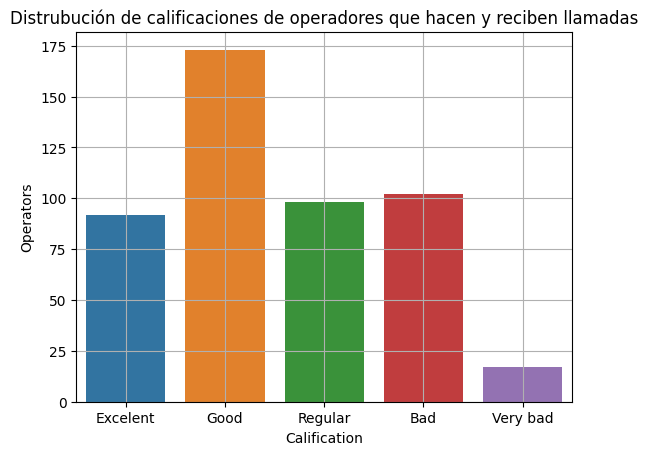

In [34]:
sns.barplot(data=standard1, x='calification', y='operator_id', estimator=len, order=['Excelent', 'Good', 'Regular', 'Bad', 'Very bad'])
plt.ylabel('Operators')
plt.xlabel('Calification')
plt.title('Distrubución de calificaciones de operadores que hacen y reciben llamadas')
plt.grid(True)

A partir del gráfico se puede apreciar que __la distribución está cargada hacia las buenas calificaciones, sin embargo hay un grupo considerable de 100 operadores que están calificados como "malos"__, en cuanto a la comparación de los extremos "Excelente" y "Muy Malo" podemos observar que los del primer grupo son muchos más.

### Operadores que solo reciben llamadas

Ahora trabajaremos con los operadores que solo reciben llamadas, de forma similar al caso anterior creamos el dataset `index2` con los filtros correspondientes de outliers y dirección de llamadas, los operadores que formarán parte de este grupo son todos los que no se trabajaron en el grupo anterior.

#### Cálculo de percentiles para los campos a evaluar

De la misma forma que con el grupo anterior, desglosamos las tasas de contestación de llamadas en percentiles para poder asignarles una nota posteriormente.

In [35]:
print(np.percentile(ar2, [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

[0.92747967 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Ahora, lo hacemos con los tiempos de espera.

In [36]:
wt2 = wt2[wt2['wait_time'] <= 180]
wt2 = wt2.groupby('operator_id')['wait_time'].mean()
print(np.percentile(wt2, [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

[ 9.         13.72142857 18.08823529 22.88648649 27.         30.61818182
 36.86634615 48.925      62.57       97.08163265]


Una vez calculados los percentiles, estamos listos para comenzar con la callficación.

#### Calificación

Para comenzar con las calificaciones, creamos `standard2`, dataset que contiene la tasa de constestación y el tiempo medio es espera de llamada por operador.

In [37]:
standard2 = ar2.reset_index().merge(wt2.reset_index(), on='operator_id')
standard2.head()

,operator_id,answering_rate,wait_time
0,882476,1.000000,31.666667
1,882478,1.000000,13.000000
2,882680,0.926829,38.736842
3,884294,1.000000,6.000000
4,884524,1.000000,9.500000


Una vez creado, definimos las funciones para calificar en base a percentiles.

In [38]:
def answering_classifier2(row):
    
    answering_rate = row['answering_rate']
    
    if answering_rate >= 1:
        return 10
    elif answering_rate >= 0.9275:
        return 2
    else:
        return 1
    
standard2['answering_p'] = standard2.apply(answering_classifier2, axis=1)
standard2.head()

,operator_id,answering_rate,wait_time,answering_p
0,882476,1.000000,31.666667,10
1,882478,1.000000,13.000000,10
2,882680,0.926829,38.736842,1
3,884294,1.000000,6.000000,10
4,884524,1.000000,9.500000,10


In [39]:
def wait_classifier2(row):
    
    wait_time = row['wait_time']
    
    if wait_time >= 62.57:
        return 10
    elif wait_time >= 48.93:
        return 9
    elif wait_time >= 36.87:
        return 8
    elif wait_time >= 30.62:
        return 7
    elif wait_time >= 27:
        return 6
    elif wait_time >= 22.89:
        return 5
    elif wait_time >= 18.09:
        return 4
    elif wait_time >= 13.72:
        return 3
    elif wait_time >= 9:
        return 2
    else:
        return 1
    
standard2['wait_p'] = standard2.apply(wait_classifier2, axis=1)
standard2['wait_p'] = 10 - standard2['wait_p']
standard2.head()

,operator_id,answering_rate,wait_time,answering_p,wait_p
0,882476,1.000000,31.666667,10,3
1,882478,1.000000,13.000000,10,8
2,882680,0.926829,38.736842,1,2
3,884294,1.000000,6.000000,10,9
4,884524,1.000000,9.500000,10,8


Con las calificaciones listas, podemos calcular la nota final.

In [40]:
standard2['score'] = (standard2['answering_p'] + standard2['wait_p']) / 2
standard2.head()

,operator_id,answering_rate,wait_time,answering_p,wait_p,score
0,882476,1.000000,31.666667,10,3,6.5
1,882478,1.000000,13.000000,10,8,9.0
2,882680,0.926829,38.736842,1,2,1.5
3,884294,1.000000,6.000000,10,9,9.5
4,884524,1.000000,9.500000,10,8,9.0


Finalmente, usamos la función `labels` creada anteriormente, para clasificar las calificaciones.

In [41]:
standard2['calification'] = standard2.apply(labels, axis=1)
standard2.head()

,operator_id,answering_rate,wait_time,answering_p,wait_p,score,calification
0,882476,1.000000,31.666667,10,3,6.5,Good
1,882478,1.000000,13.000000,10,8,9.0,Excelent
2,882680,0.926829,38.736842,1,2,1.5,Very bad
3,884294,1.000000,6.000000,10,9,9.5,Excelent
4,884524,1.000000,9.500000,10,8,9.0,Excelent


Ahora, construiremos un gráfico de barras para visualizar los resultados finales de este grupo.

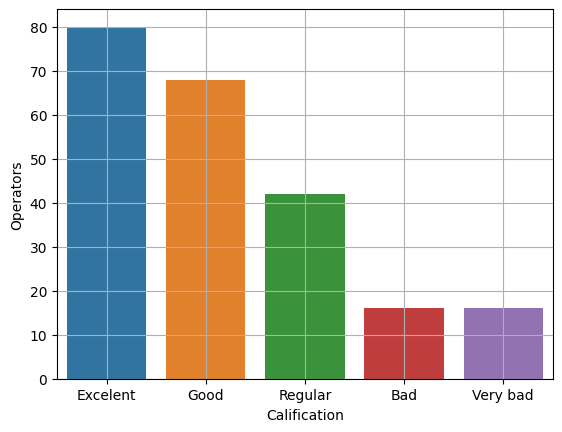

In [42]:
sns.barplot(data=standard2, x='calification', y='operator_id', estimator=len, order=['Excelent', 'Good', 'Regular', 'Bad', 'Very bad'])
plt.ylabel('Operators')
plt.xlabel('Calification')
plt.grid(True)

Las calificaciones de este grupo se ven mucho mejores que las del grupo anterior, con una predominancia de los grupos `Excelente` y `Bueno`.

## Pruebas estadísticas

La última parte de este informe constará de tres pruebas estadísticas realizadas en el dataset `standard1`, el grupo de operadores que hacen y reciben llamadas. Se usará la prueba no paramétrica de Mann-Whitney, ya que se ha observado en los gráficos anteriores que algunas distribuciones de los campos de estudio no son normales, debido a esto es que se usará la mediana (en vez de la media) como punto de comparación entre los conjuntos de datos.

- La primera hipótesis a probar es: __La tasa de contestación de llamadas es más alta en el grupo de operadores calificados como "Regular" que en el de los calificados como "Malo"__.

In [43]:
regular_answering = standard1[standard1['calification'] == 'Regular']['answering_rate']
print('Tasa de contestación mediana, grupo "Regular":', regular_answering.median().round(2))
print()
bad_answering = standard1[standard1['calification'] == 'Bad']['answering_rate']
print('Tasa de contestación mediana, grupo "Malo":' ,bad_answering.median().round(2))
print()
alpha = 0.05
results = st.mannwhitneyu(regular_answering, bad_answering)
print('valor p:', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Tasa de contestación mediana, grupo "Regular": 0.97

Tasa de contestación mediana, grupo "Malo": 0.91

valor p: 6.99853598144498e-13
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula en favor del grupo "Regular", por lo que __nuestra hipótesis es verdadera__.

- La segunda hipótesis a probar es: __La media de tiempo de espera de llamada es más alta en el grupo de operadores calificados como "Malo" que en el de los calificados como "Regular"__.

In [44]:
regular_wait = standard1[standard1['calification'] == 'Regular']['wait_time']
print('Tiempo de espera mediano por llamada, grupo "Regular":', regular_wait.median().round(2))
print()
bad_wait = standard1[standard1['calification'] == 'Bad']['wait_time']
print('Tiempo de espera mediano por llamada, grupo "Malo"', bad_wait.median().round(2))
print()
alpha = 0.05
results = st.mannwhitneyu(regular_wait, bad_wait)
print('valor p:', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Tiempo de espera mediano por llamada, grupo "Regular": 50.58

Tiempo de espera mediano por llamada, grupo "Malo" 103.96

valor p: 4.5476792621764625e-11
Rechazamos la hipótesis nula


La hipótesis nula se rechaza ampliamente en favor del grupo "Malo", por lo que __nuestro planteamiento inicial es correcto__. El que haya tanta diferencia en las medianas de los tiempos medios de espera, indica que __este campo es clave para la mejora general de los operadores del grupo "Malo"__.

- La tercera y última hipótesis a probar es: __La media semanal de llamadas realizadas del grupo "Regular" es más alta que la del grupo "Malo"__.

In [45]:
regular_out = standard1[standard1['calification'] == 'Regular']['calls_made'].dropna()
print('Mediana semanal de llamadas realizadas, grupo "Regular":' ,regular_out.median().round(2))
print()
bad_out = standard1[standard1['calification'] == 'Good']['calls_made'].dropna()
print('Mediana semanal de llamadas realizadas, grupo "Malo":', bad_out.median().round(2))
print()
alpha = 0.05
results = st.mannwhitneyu(regular_out, bad_out)
print('valor p:', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Mediana semanal de llamadas realizadas, grupo "Regular": 2.75

Mediana semanal de llamadas realizadas, grupo "Malo": 2.17

valor p: 0.003024333731053718
Rechazamos la hipótesis nula


La hipótesis nula se rechaza por muy poco en favor del grupo "Regular", lo que significa que __nuestro planteamiento inicial es correcto__.

## Clustering

Una perspectiva adicional y muy interesante es usar el clustering, para agrupar automáticamente a los operadores según caracterísitcas en común, es por eso que lo incluiremos en el informe, usándolo en el grupo de operadores que hace y recibe llamadas. Para comenzar, definimos nuestra `X`, aislando las variables en las cuales el algoritmo se basará para agrupar los datos.

In [46]:
X = standard1[['answering_rate', 'wait_time', 'calls_made']]
X.head()

,answering_rate,wait_time,calls_made
0,1.0,27.333333,3.142857
1,1.0,29.875000,4.388889
2,1.0,7.714286,3.000000
3,1.0,14.000000,2.750000
4,1.0,7.944444,4.529412


Posteriormente definimos `scaler` para estandarizar los datos y construimos un dendrograma para hacernos una idea de cuantos clústeres deberemos fijar.

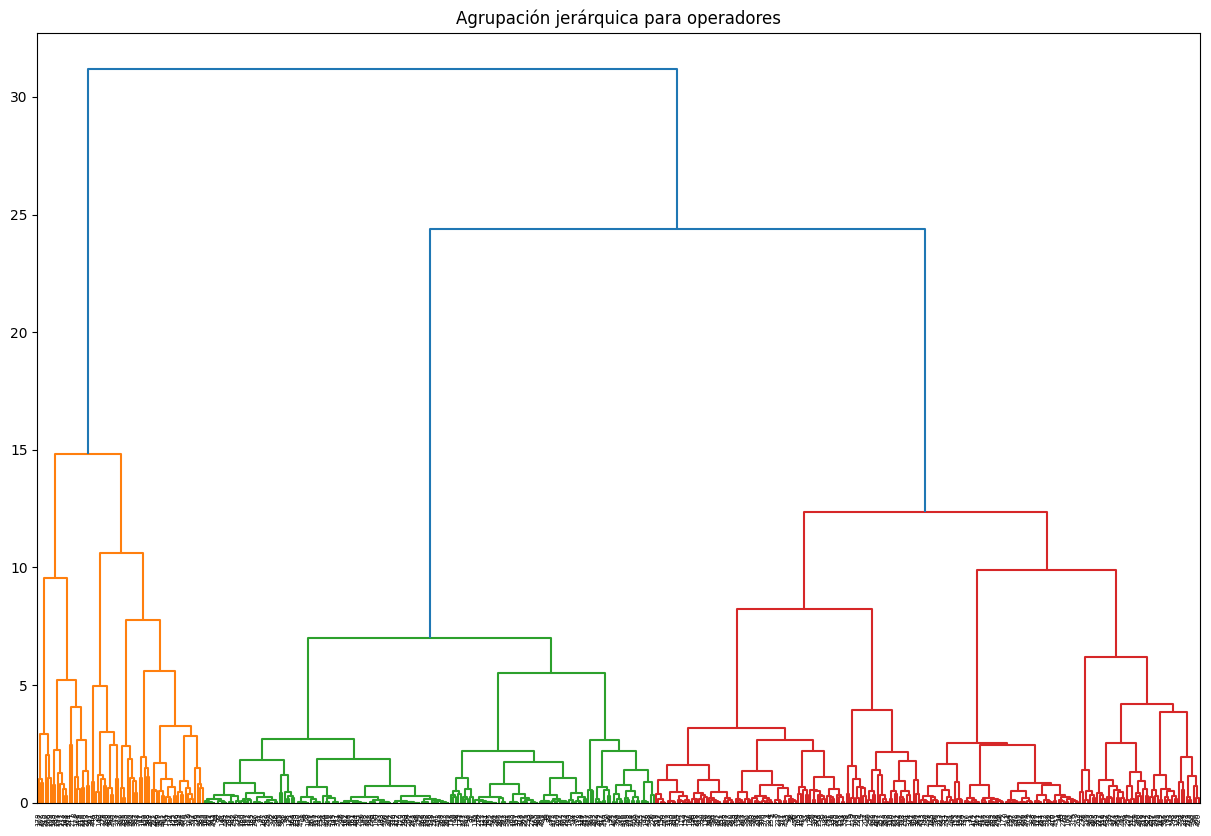

In [47]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para operadores');

Observando las ramas del gráfico, se ha determinado que 5 clústeres es un número razonable para este conjunto de datos. Entonces estamos listos para llamar al algoritmo `KMeans` y configurarlo.

In [48]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)
standard1['cluster_op'] = labels
standard1.head()

,operator_id,answering_rate,wait_time,calls_made,out_p,answering_p,wait_p,score,calification,cluster_op
0,879896,1.0,27.333333,3.142857,7,10,6,7.8,Good,1
1,879898,1.0,29.875000,4.388889,9,10,5,7.8,Good,1
2,880020,1.0,7.714286,3.000000,6,10,9,8.8,Excelent,1
3,880022,1.0,14.000000,2.750000,6,10,8,8.4,Excelent,0
4,880026,1.0,7.944444,4.529412,10,10,9,9.6,Excelent,1


Como se puede apreciar en el dataset, el algoritmo ha generado etiquetas para cada fila, por las cuales agruparemos el dataset y calcularemos la en todas las columnas. Se incluirán ahora también las calificaciones generadas por percentiles, de esta forma podemos observar el promedio en puntaje de cada clúster.

In [49]:
standard1.drop(columns='operator_id').groupby('cluster_op').mean()

,answering_rate,wait_time,calls_made,out_p,answering_p,wait_p,score
cluster_op,,,,,,,
0,0.988711,33.684807,1.680076,3.571429,8.852535,5.741935,6.552074
1,0.982089,43.727906,3.936930,8.319527,7.603550,4.568047,6.532544
2,0.706256,127.262252,2.383788,5.200000,1.000000,2.080000,2.272000
3,0.873556,350.298490,2.745527,5.952381,3.285714,0.000000,2.504762
4,0.890876,139.860891,3.890963,8.160000,2.380000,1.220000,3.072000


Podemos rescatar insights muy valiosos de esta tabla, tales como:
- Los operadores del cluster con mejor puntaje hacen pocas llamadas, pero tienen tiempos de espera y tasas de contestación excelentes.
- Los operadores del cluster con peor puntaje hacen una buena cantidad de llamadas, pero tienen bajo desempeño en tasa de contestación y tiempos de espera.
- De lo anterior se puede extraer como conclusión, que __lo más importante para ser un buen operador es establecer el siguiente orden de prioridades:__
    - __1, Tasa de contestación__.
    - __2, Tiempos de espera__.
    - __3, Llamadas realizadas__.
    
Ahora, visualizaremos mediante gráficos de dispersión las relaciones de las variables entre sí, esto nos puede ayudar a confirmar lo que descubrimos y a rescatar nuevos insights que aún se encuentren ocultos. Comenzamos definiendo una función para construir los gráficos.

In [50]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
          hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

Comenzamos con la relación de los tiempos de espera y la tasa de contestación.

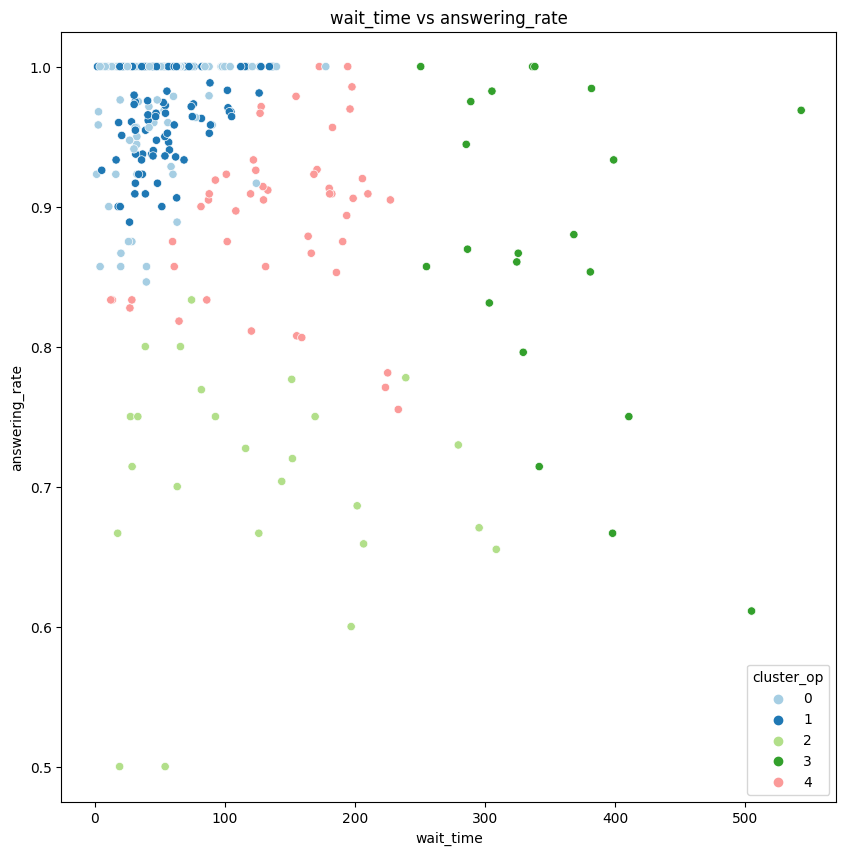

In [51]:
show_clusters_on_plot(standard1, 'wait_time', 'answering_rate', 'cluster_op')

Aquí se observa claramente la división de los clusteres, los grupos 0 y 1 se encuentran arrinconados en la esquina superior izquierda (excelentes tasas de contestación y tiempos de espera) seguidos por el grupo 4, el grupo 3 se ve disperso en el lado derecho del gráfico (tiempos de espera altos) y el grupo 2 se observa en la parte inferior (baja tasa de contestación).

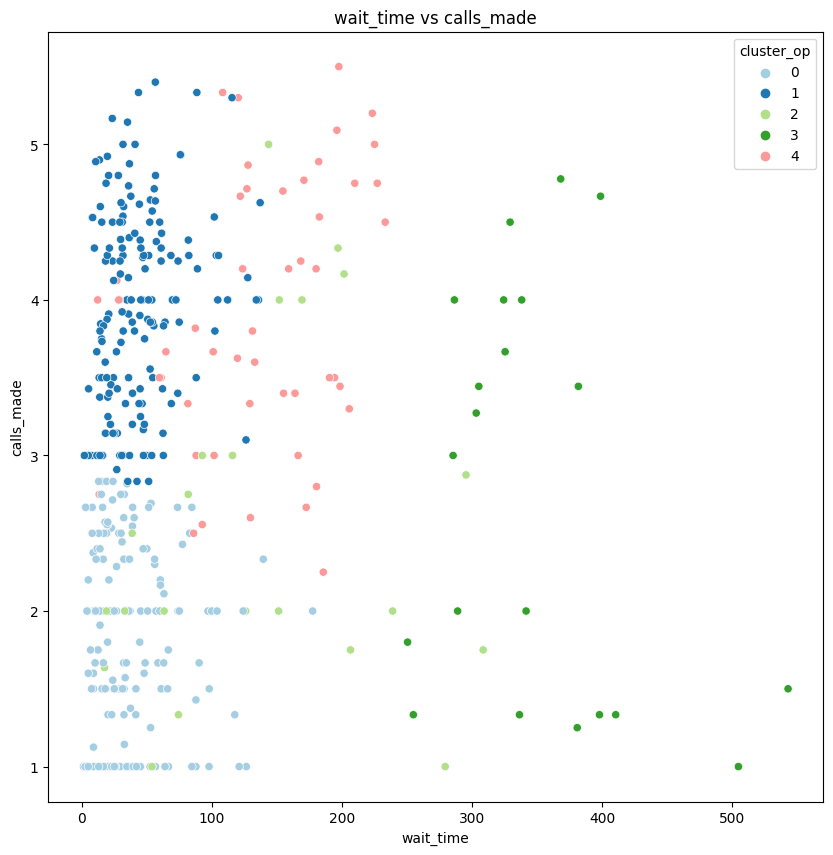

In [52]:
show_clusters_on_plot(standard1, 'wait_time', 'calls_made', 'cluster_op')

En este gráfico se puede apreciar que el cluster 0 hace muy pocas llamadas.

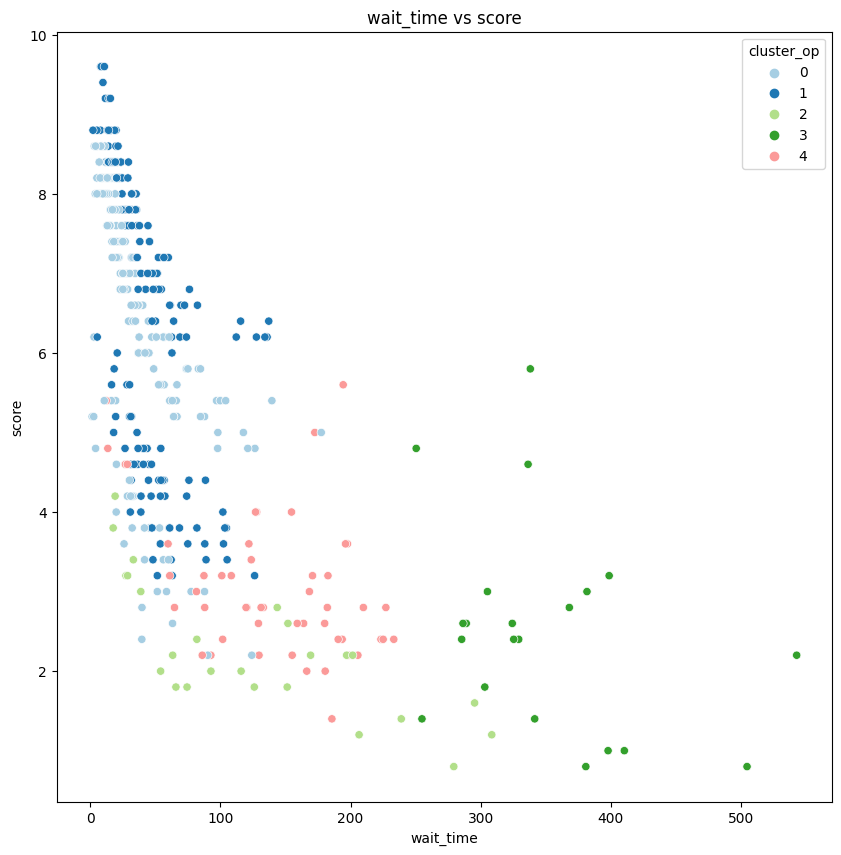

In [53]:
show_clusters_on_plot(standard1, 'wait_time', 'score', 'cluster_op')

Este gráfico ilustra sobre como, en general, hay una alta correlación entre la tasa de contestación y los puntajes de los operadores.

## Conclusiones

En este apartado se desarollarán ampliamente todas las conclusiones obtenidas en el desarrollo del informe, haciendo hincapié en los aspectos fundamentales del trabajo, como lo son: el resumen de los hallazgos clave, impacto de elecciones de preprocesamiento, relevancia de los hallazgos, sugerencias y las reflexiones finales sobre el desarrollo de esta tarea.

### Resumen de hallazgos clave

Los principales hallazgos encontrados en el análisis exploratorio y las pruebas estadísticas son:

- El rendimiento general de los operadores en cuanto a contestación del __es muy bueno, especialmente el del grupo que solo recibe llamadas__, que cuenta con un 81.5% de operadores con una tasa de contestación perfecta.
- El rendimiento general de los operadores en cuanto a tiempos de espera __es bueno, pero mejorable__, el grupo con mejores números es el grupo que solo recibe llamadas con un 77.1% de los operadores promediando menos de un minuto en tiempo de espera.
- En cuanto a las llamadas salientes, __la mitad hace una cantidad aceptable de llamadas a la semana__, siendo un 51.1% de los operadores que hacen más de 3.5 llamadas a la semana en promedio.
- __El rendimiento general de los operadores que solo reciben llamadas es mejor que el de los que reciben y hacen llamadas__, estos últimos tienen peor desempeño en tiempos de espera y tasa de contestación.
- En cuanto a los operadores que hacen y reciben llamadas, __es clave mejorar los tiempos de espera medios de llamada para subir las calificaciones del grupo "Malo" y llevarlas a "Regular"__.

Los principales hallazgos encontrados en el análisis de clústers son:

- Los operadores de cluster con mejor puntaje hacen pocas llamadas, pero tienen tiempos de espera y tasas de contestación excelentes.
- Los operadores del cluster con peor puntaje hacen una buena cantidad de llamadas, pero tienen bajo desempeño en tasa de contestación y tiempos de espera.
- De lo anterior se puede extraer como conclusión, que __lo más importante para ser un operador excelente es establecer el siguiente orden de prioridades:__
    - __1, Tasa de contestación__.
    - __2, Tiempos de espera__.
    - __3, Llamadas realizadas__.

### Impacto de elecciones de pre-procesamiento de datos

- Una de las principales elecciones de preprocesamiento de este trabajo fue el eliminar los valores los ausentes, sin embargo, en el caso de los valores ausentes, como estos eran en la columna `operator_id`, __el impacto de eliminarlos, sea cual sea la cantidad, es casi nulo__, ya que este trabajo consta exclusivamente de calificar el rendimiento individual de los operadores.
- La decisión de eliminar los duplicados (un 9.2% del total de los datos), sin duda, fue la más drástica de todas, sin embargo se evaluó en detalle el riesgo mediante un análisis detallado y se descubrió que __eliminarlos no cambiaría las proporciones de ninguna de las columnas__, por lo cual se, tomó la decisión de hacerlo.
- En cuanto al tratamiento de outliers, para efectos de la creación del sistema de clasificación, en la columna `wait_time` __se dejo el tope máximo en 2.000 segundos como tiempo máximo de espera, consideránse valor atípico todo valor superior. Para tomar esta decisión, nos guiamos por un gráfico de dispersión y el cálculo de percentiles extremos__, sin embargo un conocimiento mayor del sistema de registro de llamadas o del contexto laboral de los operadores podría ayudar a ajustar el filtro con mayor precisión.

### Relevancia de los hallazgos y recomendaciones

- Los hallazgos encontrados pueden servir para mejorar enormemente el de los operadores, el sistema de calificación está configurado poder ser automatizado y actualizado semana a semana, y en esa misma línea, __se podría enviar correos automatizados semanalmente con recomendaciones personalizadas basadas en puntos débiles para cada uno de los operadores__.

- Para potenciar el rendimiento se podría, también, __premiar a los operadores que entren en la categoría "Excelente" y/o dar un premio al subir de categoría__, los premios pueden ser, por ejemplo: un bono económico, un sorteo entre quienes entren en la categoría, o un día extra de vacaciones.

- __Para mejorar la precisión del sistema se debe eliminar la generación de outliers__, ya que estos pueden afectar negativamente la calificación de un operador. 

- El sistema está construído para poder modificar cualquiera de las partes, se puede reemplazar el sistema de percentiles por intervalos regulares y/o modificar la ponderación del índice de calificación, __es posible que deban realizarse modificaciones considerando que el sistema fue construído sin conocer en detalle el contexto de la compañía y el día a día del trabajo de los operadores__.

### Reflexiones finales

A pesar de que el sistema pueda seguir mejorando con información adicional, quedo muy conforme con el resultado, ya que este trabajo se realizó pensando en poder ser aplicado al mundo real, y considero que con las respectivos ajustes segun el contexto de uso, el sistema podría funcionar en un contexto real, para ayudar a mejorar el rendimiento de operadores de call center (y potencialmente otras áreas de trabajo) mediante recomendaciones personalizadas automatizadas, lo cual supondría un gran avance en las áreas de control de calidad de diversas empresas, ya que, en la gran mayoría de las organizaciones este proceso se realiza de manera manual.

Fue un trabajo muy desafiante y la primera vez que hacía un sistema de clasificación de este tipo, aprendí muchas cosas que no sabía hacer y que me ayudarán a ser mejor profesional en el futuro. Quedo atento a cualquier retroalimentación y consejo de mejora para poder seguir puliendo este trabajo.